<a href="https://colab.research.google.com/github/SupawatDev/path-loss-tester/blob/master/path_loss_tester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Path Loss Tester
Path Loss tester is a tool to verify the result of electromagnetic propagation loss from the generated data from WCsim.

In [1]:
from google.colab import files
from math import pi, log10, cos, sin, asin
import numpy as np
import pandas as pd
import io
c = 3e8

### Import the data

In [2]:
print("Upload files.")
upload = files.upload()

Upload files.


Saving direct_path.csv to direct_path.csv
Saving reflection.csv to reflection.csv
Saving single-edge.csv to single-edge.csv
Saving multiple-edges.csv to multiple-edges.csv


In [3]:
#Load .csv data to Pandas
direct_data = pd.read_csv(io.BytesIO(upload['direct_path.csv']))
ref_data = pd.read_csv(io.BytesIO(upload['reflection.csv']))
single_edge_data = pd.read_csv(io.BytesIO(upload['single-edge.csv']))
multi_edges_data = pd.read_csv(io.BytesIO(upload['multiple-edges.csv']))
direct_data.head()

,tx_x_pos,tx_y_pos,tx_z_pos,tx_freq,rx_x_pos,rx_y_pos,rx_z_pos,distance,path_loss_dB
0,0,5,0,2.300000e+09,34,1.5,-59,68.1854,76.3502
1,0,5,0,2.300000e+09,24,1.5,0,24.2539,67.3719
2,0,5,0,2.300000e+09,42,1.5,-9,43.0958,72.3650
3,0,5,0,2.300000e+09,-5,1.5,16,17.1245,64.3487
4,0,5,0,2.300000e+09,12,1.5,38,40.0031,71.7182


## Direct Path Verification

\begin{equation}
Loss_{direct} = (\frac{4\pi d_1}{\lambda})^2
\end{equation}

In [4]:
# Function for calculating direct path loss of radio wave propagation.
def DirectPath(tx_positions, frequencies, rx_positions):
  distance = np.sqrt(np.sum((tx_positions-rx_positions)**2, axis=1))
  wave_length = c/frequencies
  distance = np.reshape(distance, (-1,1))
  wave_length = np.reshape(wave_length, (-1,1))
  path_loss = (4*pi*distance/wave_length)**2 # <---- Formula
  return 10*np.log10(path_loss)

In [5]:
tx_positions = direct_data.iloc[:,0:3].to_numpy()
tx_frequencies = direct_data.iloc[:,3:4].to_numpy()
rx_positions = direct_data.iloc[:,4:7].to_numpy()
computed_result = DirectPath(tx_positions, tx_frequencies, rx_positions).reshape(-1,1)
reference_result = direct_data.iloc[:,-1].to_numpy().reshape((-1,1))
# Round to 1 digit because the PI value in simulator is not accurate.
check_table = pd.DataFrame( {'com':computed_result.ravel(), 'ref': reference_result.ravel()})
assert (np.round(computed_result, 1) == np.round(reference_result, 1)).all()
print("Direct Path Results are correct.")
check_table.head()

Direct Path Results are correct.


,com,ref
0,76.350158,76.3502
1,67.371948,67.3719
2,72.365033,72.3650
3,64.348709,64.3487
4,71.718207,71.7182


## Reflection Verification

### Reflection Coefficient

\begin{equation}
  \Gamma_{TE} = 
  \begin{cases}
    1 , & \text{ where \( \sqrt{\vert \frac{n_1}{n_2} \vert sin\theta_1 } >=1 \) } \\
         \frac {\sqrt{n_2} cos(\theta_1) - \sqrt{n_2} cos(\theta_2)}
          {\sqrt{n_1} cos(\theta_1) + \sqrt{n_2} cos(\theta_2)} , &  \text{ else }
  \end{cases}
\end{equation}


\begin{equation}
  \Gamma_{TM} =
\end{equation}

In [6]:
ref_data.head()

,tx_x_pos,tx_y_pos,tx_z_pos,tx_freq,rx_x_pos,rx_y_pos,rx_z_pos,ref_x_pos,ref_y_pos,ref_z_pos,tm_or_te,ref_coeff,d1,d2,angle2norm_deg,ref_loss_dB
0,0,5,0,2.300000e+09,34,1.5,-59,36.1217,2.834910,-30.0909,E,-0.646290,47.0630,29.01760,62.83030,81.0933
1,0,5,0,2.300000e+09,34,1.5,-59,26.1838,0.010512,-45.4366,E,-0.912804,52.6779,15.72510,84.56490,77.1703
2,0,5,0,2.300000e+09,24,1.5,0,64.1040,2.846930,0.0000,E,-0.394866,64.1402,40.12660,1.92368,88.1103
3,0,5,0,2.300000e+09,24,1.5,0,18.4833,0.010678,0.0000,E,-0.778438,19.1448,5.71422,74.89300,69.7615
4,0,5,0,2.300000e+09,42,1.5,-9,41.3905,1.596380,-10.0407,E,-0.568004,42.7267,1.20995,53.49560,77.4458


In [7]:
tx_positions = ref_data.iloc[:,0:3].to_numpy().reshape((-1,3))
tx_frequencies = ref_data.iloc[:,3:4].to_numpy().reshape((-1,1))
rx_positions = ref_data.iloc[:,4:7].to_numpy().reshape((-1, 3))
ref_positions = ref_data.iloc[:,7:10].to_numpy().reshape((-1,3))
angles = ref_data.iloc[:, -2:-1].to_numpy().reshape((-1, 1))

In [8]:
def ReflectionCoefficient(tx_positions, rx_positions, angle2norm_deg, n_1, n_2, polar):
  angle_1 = np.radians(angle2norm_deg)

  c1, c2 = c/np.sqrt(n_1), c/np.sqrt(n_2)
  angle_2 = np.arcsin(c2*np.sin(angle_1)/c1)

  if polar == 'TE':
    answer = (np.sqrt(n_1)*np.cos(angle_1) - np.sqrt(n_2)*np.cos(angle_2))/ \
           (np.sqrt(n_1)*np.cos(angle_1) + np.sqrt(n_2)*np.cos(angle_2))

  if polar == 'TM':
    answer = (np.sqrt(n_2)*np.cos(angle_1) - np.sqrt(n_1)*np.cos(angle_2))/ \
           (np.sqrt(n_2)*np.cos(angle_1) + np.sqrt(n_1)*np.cos(angle_2))

  for i in range(len(tx_positions)):
    if np.sqrt(np.abs(n_1/n_2)*np.sin(angle_1[i]) ) >= 1:
      answer[i] = 1

  return answer

In [9]:
angles = ref_data.iloc[:, -2:-1].to_numpy().reshape((-1, 1))

In [10]:
computed_refl_coe = ReflectionCoefficient(tx_positions, rx_positions, angles, 1.0003, 5.31, 'TE' ).reshape((-1,1))
ref_refl_coe = ref_data.iloc[:,-5].to_numpy().reshape((-1,1))
check_table = pd.DataFrame( {'computed coefficients':computed_refl_coe.ravel(), 'reference coefficients': ref_refl_coe.ravel()})
assert (np.round(computed_refl_coe,2) == np.round(ref_refl_coe,2)).all()
print("Reflection Coefficient Results are correct.")
check_table.head()

Reflection Coefficient Results are correct.


,computed coefficients,reference coefficients
0,-0.646290,-0.646290
1,-0.912805,-0.912804
2,-0.394866,-0.394866
3,-0.778438,-0.778438
4,-0.568004,-0.568004


### Reflection Loss
\begin{equation}
Loss_{reflect} = (\frac{4\pi (d_1+d_2)}{\lambda \Gamma})^2
\end{equation}

In [11]:
def ReflectionLoss(tx_positions, frequencies, rx_positions, ref_positions,  ref_coefficients):
  d_1 = np.sqrt(np.sum((tx_positions-ref_positions)**2, axis=1))
  d_2 = np.sqrt(np.sum((rx_positions-ref_positions)**2, axis=1))
  wave_lengthes = c/frequencies
  loss = (4*pi*(d_1+d_2)/np.multiply(wave_lengthes.ravel(),ref_coefficients.ravel()))**2
  return 10*np.log10(loss)

In [12]:
computed_reflection_loss = ReflectionLoss(tx_positions, tx_frequencies, rx_positions, ref_positions, computed_refl_coe)
ref_reflection_loss = ref_data.iloc[:, -1].to_numpy()
ref_loss_table = pd.DataFrame( {'computed result [dB]':computed_reflection_loss.ravel(), 'reference result [dB]': ref_reflection_loss.ravel()})
assert (np.round(computed_reflection_loss, 1) == np.round(ref_reflection_loss,1) ).all()
print("Reflection Loss Result are correct")
ref_loss_table.head()

Reflection Loss Result are correct


,computed result [dB],reference result [dB]
0,81.093258,81.0933
1,77.170282,77.1703
2,88.110253,88.1103
3,69.761543,69.7615
4,77.445838,77.4458


## Diffraction Verification

In [13]:
single_edge_data.head()

,tx_x_pos,tx_y_pos,tx_z_pos,tx_freq,rx_x_pos,rx_y_pos,rx_z_pos,edge_x_pos,edge_y_pos,edge_z_pos,d1,d2,v,diff_loss_dB,free_space_loss,total_loss_dB
0,0,5,0,2.300000e+09,62,1.5,-22,49.2605,32.1573,-17.4795,58.9037,33.5053,21.3885,39.4883,76.0515,115.540
1,0,5,0,2.300000e+09,45,1.5,-36,35.3552,26.6196,-28.2842,50.1736,27.9920,19.3120,38.5979,74.9050,113.503
2,0,5,0,2.300000e+09,61,1.5,-19,51.8878,31.8698,-16.1618,60.6262,31.8342,21.2488,39.4312,75.7981,115.229
3,0,5,0,2.300000e+09,53,1.5,-96,28.3248,21.4339,-51.3053,60.8654,54.8073,12.9921,35.1401,80.4816,115.622
4,0,5,0,2.300000e+09,71,1.5,-53,67.7635,29.3966,-50.5840,88.0104,28.1874,20.5179,39.1260,78.6318,117.758


### Single Edge Diffraction

\begin{equation}
  v = h \sqrt{\frac{2(s_1+s_2)}{\lambda r_1 r_2}}
\end{equation}

\begin{equation}
  c_{K.E.} = 6.9 + 20log(\sqrt{(v-0.1)^2 + 1} + v - 0.1 )
\end{equation}

In [14]:
tx_positions = single_edge_data.iloc[:,0:3].to_numpy().reshape((-1,3))
tx_frequencies = single_edge_data.iloc[:,3:4].to_numpy().reshape((-1,1))
rx_positions = single_edge_data.iloc[:,4:7].to_numpy().reshape((-1, 3))
edge_positions = single_edge_data.iloc[:,7:10].to_numpy().reshape((-1,3))
ref_v_values = single_edge_data.iloc[:,-4].to_numpy().reshape((-1,1))
ref_total_loss = single_edge_data.iloc[:,-1].to_numpy().reshape((-1,1))
ref_diff_loss = single_edge_data.iloc[:,-3].to_numpy().reshape((-1,1))
ref_fsp_loss = single_edge_data.iloc[:,-2].to_numpy().reshape((-1,1))

In [15]:
def NormalzeVector(matrix):
  norm = np.sqrt(np.sum( matrix**2,axis=1, keepdims=True))
  matrix = matrix/ norm
  return matrix

In [16]:
# Function that computes the angle between two vectors
def AngleTwoVector(vectors_1, vectors_2):
  numerator = np.sum(np.multiply(vectors_1, vectors_2),axis=1); 
  denumerator = np.multiply(np.sqrt(np.sum(vectors_1**2,axis=1)), np.sqrt(np.sum(vectors_2**2,axis=1)))
  return np.arccos(numerator/denumerator)

In [17]:
def ComputeV(tx_positions, tx_frequencies, rx_positions, edge_positions):
  tx2rx_dir = NormalzeVector(rx_positions-tx_positions)
  rx2tx_dir = -tx2rx_dir
  tx2edge_dir = NormalzeVector(edge_positions-tx_positions)
  rx2edge_dir = NormalzeVector(edge_positions-rx_positions)
  angle_tx = AngleTwoVector(tx2edge_dir, tx2rx_dir).ravel()
  angle_rx = AngleTwoVector(rx2edge_dir, rx2tx_dir).ravel()
  wave_length = c/tx_frequencies.ravel()
  r1 = np.sqrt(np.sum((tx_positions-edge_positions)**2, axis=1)).ravel()
  r2 = np.sqrt(np.sum((rx_positions-edge_positions)**2, axis=1)).ravel()
  d1 = np.multiply(np.cos(angle_tx),r1).ravel()
  d2 = np.multiply(np.cos(angle_rx),r2).ravel()
  h1 = np.multiply(np.sin(angle_tx),r1).ravel()
  h2 = np.multiply(np.sin(angle_rx),r2).ravel()
  assert (np.round(h1,2) == np.round(h2,2)).all() # h should be equal
  h = h1
  v = np.multiply(h, np.sqrt(2*(d1 + d2)/(wave_length*r1*r2)))
  return v

In [18]:
def ComputeDiffractionFromV(v_list):
  v = v_list.ravel()
  return 6.9 + 20 * np.log10(np.sqrt((v_list - 0.1)**2 + 1) + v_list - 0.1)

In [19]:
computed_v = ComputeV(tx_positions, tx_frequencies, rx_positions, edge_positions)
computed_v = computed_v.ravel()
ref_v_values = ref_v_values.ravel()
assert (np.round(computed_v, 1) == np.round(ref_v_values, 1) ).all()
v_table = pd.DataFrame( {'computed V':computed_v, 'reference V': ref_v_values})
print("V Results are correct")
v_table.head()

V Results are correct


,computed V,reference V
0,21.388500,21.3885
1,19.311991,19.3120
2,21.248819,21.2488
3,12.992119,12.9921
4,20.517852,20.5179


In [20]:
#computed_single_loss = ComputeDiffractionFromV(computed_v) \
#                        + DirectPath(tx_positions, tx_frequencies, rx_positions);
computed_single_loss = ComputeDiffractionFromV(computed_v).ravel()
ref_diff_loss = ref_diff_loss.ravel()

single_result_table = pd.DataFrame( {'computed diff loss': computed_single_loss,\
                                     'reference diff loss': ref_diff_loss})

assert (np.round(computed_single_loss, 1) == np.round(ref_diff_loss, 1) ).all()
print("Single Diffraction Results are correct")
single_result_table.head()

Single Diffraction Results are correct


,computed diff loss,reference diff loss
0,39.488289,39.4883
1,38.597924,38.5979
2,39.431173,39.4312
3,35.140122,35.1401
4,39.126005,39.1260


### Multiple Edges Diffraction

\begin{equation}
  C_1 = C(P_{Tx}, P_{Tx \ edge}, P_{center\ edge}) \\
\end{equation}
\begin{equation}
  C_2 = C(P_{Tx}, P_{center\ edge}, P_{Rx})\\
\end{equation}
\begin{equation}
  C_3 =  C(P_{center\ edge}, P_{Rx \ edge}, P_{Rx})\\
\end{equation}
\begin{equation}
  C_d = C_2 + C_1 + C_3 - \hat{C_1} - \hat{C_2}
\end{equation}

In [21]:
multi_edges_data.head()

,tx_x_pos,tx_y_pos,tx_z_pos,tx_freq,rx_x_pos,rx_y_pos,rx_z_pos,near_tx_x_pos,near_tx_y_pos,near_tx_z_pos,center_x_pos,center_y_pos,center_z_pos,near_rx_x_pos,near_rx_y_pos,near_rx_z_pos,d1,d2,d3,d4,v_near_tx,v_cen,v_near_rx,c_v_near_tx,c_v_cen,c_v_near_rx,c1_correct,c2_correct,diff_los_dB,free_space_loss,total_loss_dB
0,0,5,0,2.300000e+09,91,1.5,-73,35.40520,26.4376,-28.4020,64.7376,31.6842,-51.9324,66.3098,31.7675,-53.1936,50.1973,37.968300,2.01735,43.7952,5.45653,19.6483,3.94294,27.5730,38.7485,24.7573,-2.630610,-7.655860,101.365,81.0188,182.384
1,0,5,0,2.300000e+09,-71,1.5,93,-29.59120,27.5186,38.7602,-50.7980,31.8976,66.5382,-61.8813,26.7216,81.0558,53.7129,35.221100,18.98390,29.3589,5.50555,19.7757,9.45856,27.6508,38.8048,32.3695,-2.747610,-0.264993,101.838,81.0442,182.882
2,0,5,0,2.300000e+09,77,1.5,-30,46.67420,31.7181,-18.1847,47.3652,31.6293,-18.4540,54.0084,26.1107,-21.0422,56.7716,0.746949,9.01590,34.8502,1.92332,20.4244,1.31133,18.7277,39.0862,15.7875,-14.090100,-14.269100,101.961,78.0277,179.988
3,0,5,0,2.300000e+09,-93,1.5,-52,-37.85300,20.0334,-21.1651,-75.1767,31.6728,-42.0343,-77.5457,29.1664,-43.3589,45.9001,44.317700,3.69450,32.8471,1.26255,20.7999,1.80862,15.5145,39.2450,18.2367,-7.152610,-13.760200,93.909,80.2321,174.141
4,0,5,0,2.300000e+09,19,1.5,-100,7.78413,29.5944,-40.9691,17.1596,31.7358,-90.3139,17.7837,29.6554,-93.5985,48.4143,50.273200,3.93781,28.8995,9.29634,21.3988,5.24474,32.2185,39.4925,27.2288,-0.347589,-5.001980,104.289,79.8355,184.125


In [79]:
tx_positions = multi_edges_data.iloc[:,0:3].to_numpy().reshape((-1,3))
tx_frequencies = multi_edges_data.iloc[:,3].to_numpy().reshape((-1,1))
rx_positions = multi_edges_data.iloc[:,4:7].to_numpy().reshape((-1, 3))
near_tx_edges = multi_edges_data.iloc[:,7:10].to_numpy().reshape((-1,3))
center_edges = multi_edges_data.iloc[:,10:13].to_numpy().reshape((-1,3))
near_rx_edges = multi_edges_data.iloc[:,13:16].to_numpy().reshape((-1,3))

ref_c_tx = multi_edges_data.iloc[:, -8].to_numpy().ravel()
ref_c_cen = multi_edges_data.iloc[:, -7].to_numpy().ravel()
ref_c_rx = multi_edges_data.iloc[:, -6].to_numpy().ravel()

ref_c1_cor =  multi_edges_data.iloc[:, -5].to_numpy().ravel()
ref_c2_cor =  multi_edges_data.iloc[:, -4].to_numpy().ravel()

In [23]:
computed_c_tx = ComputeDiffractionFromV(ComputeV(tx_positions, tx_frequencies, center_edges, near_tx_edges)).ravel()
computed_c_cen = ComputeDiffractionFromV(ComputeV(tx_positions, tx_frequencies, rx_positions, center_edges)).ravel()
computed_c_rx = ComputeDiffractionFromV(ComputeV(center_edges, tx_frequencies, rx_positions, near_rx_edges)).ravel()


In [24]:
assert  (computed_c_tx.round(0) == ref_c_tx.round(0)).all() and \
        (computed_c_cen.round(0) == ref_c_cen.round(0)).all() and \
        (computed_c_rx.round(0) == ref_c_rx.round(0)).all()

c_table = pd.DataFrame( {'computed C near TX': computed_c_tx,\
                         'reference C near X': ref_c_tx,\
                         'computed C center': computed_c_cen,\
                         'referenced C center': ref_c_cen,\
                         'computed C near RX': computed_c_rx,\
                         'referenced C near RX': ref_c_rx })
print('Multiple Diffraction Result are correct.')

Multiple Diffraction Result are correct.


In [25]:
c_table.head(4)

,computed C near TX,reference C near X,computed C center,referenced C center,computed C near RX,referenced C near RX
0,27.572922,27.5730,38.748462,38.7485,24.757198,24.7573
1,27.650739,27.6508,38.804814,38.8048,32.369435,32.3695
2,18.738836,18.7277,39.086212,39.0862,15.787828,15.7875
3,15.513988,15.5145,39.245023,39.2450,18.237056,18.2367


### Correction
\begin{equation}
  cos\alpha_1 = \sqrt{\frac{(d_1(d_3+d_4))}{(d_1+d_2)(d_2+d_3+d_4)}}
\end{equation}
\begin{equation}
  cos\alpha_2 = \sqrt{\frac{(d_4(d_1+d_2))}{(d_3+d_4)(d_2+d_3+d_1)}}
\end{equation}



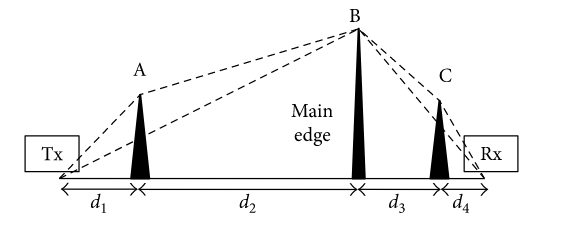

In [74]:
def CorrectionCos(tx_positions, near_tx_edges, center_edges, near_rx_edges, rx_positions):
  # Shallow copy 
  p1, p2, p3 = np.copy(tx_positions), np.copy(near_tx_edges), np.copy(center_edges)
  p4, p5 = np.copy(near_rx_edges), np.copy(rx_positions)
  # Convert positions to be on ground plane.
  p1[:,1], p2[:,1], p3[:,1], p4[:,1], p5[:,1] = 0,0,0,0,0
  # get distance d1, d2, d3, d4.
  d1 =  np.sqrt(np.sum((p2-p1)**2, axis=1)).ravel()
  d2 =  np.sqrt(np.sum((p3-p2)**2, axis=1)).ravel()
  d3 =  np.sqrt(np.sum((p4-p3)**2, axis=1)).ravel()
  d4 =  np.sqrt(np.sum((p5-p4)**2, axis=1)).ravel()
  # insert ds according to the formulas above.
  cos1 = np.sqrt( np.multiply(d1, (d3+d4))/np.multiply(d1+d2, d2+d3+d4) )
  cos2 = np.sqrt( np.multiply(d4, (d1+d2))/np.multiply(d3+d4, d2+d3+d1))
  return cos1, cos2

In [78]:
cos1, cos2 = CorrectionCos(tx_positions, near_tx_edges, center_edges, near_rx_edges, rx_positions)
c_cap_1 = (6 - computed_c_cen + computed_c_tx)*cos1
c_cap_2 = (6 - computed_c_cen + computed_c_rx)*cos2

print(c_cap_1) 
print(c_cap_2)

[ -2.63063698  -2.74763536 -14.07912939  -7.15279101  -0.34759527
  -2.55210378  -1.74788613  -7.01336932  -2.0502593  -25.09588246
  -1.57769785]
[-7.65596844e+00 -2.65020864e-01 -1.42688321e+01 -1.37598986e+01
 -5.00187320e+00 -1.05966721e+01 -2.53399415e+01 -2.70411618e+01
 -2.08210775e-02 -4.18938247e-03 -7.74516283e+00]


In [94]:
correct_table = pd.DataFrame( { 'computed Correct 1': c_cap_1,\
                                'reference Correct 1': ref_c1_cor,\
                                'computed Correct 2': c_cap_2,\
                                'referenced Correct 2': ref_c2_cor})

In [95]:
assert  (c_cap_1.round(0) == ref_c1_cor.round(0)).all() and \
        (c_cap_2.round(0) == ref_c2_cor.round(0)).all()
print('Diffraction Correction Result are correct.')
correct_table.head()

Diffraction Correction Result are correct.


,computed Correct 1,reference Correct 1,computed Correct 2,referenced Correct 2
0,-2.630637,-2.630610,-7.655968,-7.655860
1,-2.747635,-2.747610,-0.265021,-0.264993
2,-14.079129,-14.090100,-14.268832,-14.269100
3,-7.152791,-7.152610,-13.759899,-13.760200
4,-0.347595,-0.347589,-5.001873,-5.001980
